In [56]:
import utils
import cv2
import imutils
import glob
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
import skimage
from sklearn.cluster import KMeans
from collections import Counter
from scipy.spatial import distance
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from tqdm.notebook import trange,tqdm

In [2]:
train = True

## ImageMerger

In [4]:
class ImageMerger:
    """
    ImageMerger can merge images from a dataset including images collected by a drone with the purpose of detecting 
    moving people in the images.
    """
    def __init__(self, data_dir, mask_file):
        """
        :param data_dir: path to the directory where the data is located
        :param mask_file: path of a mask which removes unneccesary text from the images
        """
        
        # Get all directories inside the data_dir
        self.data_dir = data_dir
        self.dirs = os.listdir(data_dir)
        self.mask = np.array(cv2.imread(mask_file)) // 255
        
        # Store the merged images
        self.merged_images = {}
        
    def load_images(self):
        """
        Loads the images and homographies from one directory at a time and yields them
        """
        
        for a_dir in self.dirs:
            if a_dir == 'labels.json':
                continue
            input_images = {}
            
            # Load all images in the train directory
            image_dir_file_path = os.path.join(os.path.join(self.data_dir, a_dir), '*.png')
            images = glob.glob(image_dir_file_path)
            
            # Copy all the raw images to the input images dict
            for im in images:
                file = os.path.basename(im)
                img_name = os.path.splitext(file)[0]
                src = cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB)
                src = self.apply_mask(src)
                input_images[img_name] = src
            
            # Load the homographies json file
            homographies_file_path = os.path.join(os.path.join(self.data_dir, a_dir), 'homographies.json')
            with open(homographies_file_path, 'rb') as f:
                homographies = json.load(f)
            
            yield a_dir, input_images, homographies
        
    def apply_mask(self, image):
        """
        Applys the provided mask on image
        :param image: image file which will be treated as np.array
        """

        return image * self.mask
    
    def merge_images(self, alpha=0.75, axis=0, method='ltr', debug=False):
        """
        Merges all the images given the homographies which are retrieved from load_data. 
        :param alpha: Weighting for merging the images. The image to be merged on will be considered with a weight a alpha,
        the second image with a weight of 1-alpha.
        :param axis: defines the axis along which the images shall be merged. 0: camera axis, 1: time axis
        :param method: defines in which order the images shall be merged:
            - ltr:  The images are merged from left to right along the camera axis or from the first in time (index 0) 
                    to the last in time (index 6)
            - rtl:  The images are merged from right to left along the camera axis or from the last in time (index 6) 
                    to the first in time (index 0)
            - outl: The images are merged from the center out switching between the left and right side of the center 
                    (along camera axis)/previous and next in time (along time axis) starting with the left side/previous 
                    in time. 
            - outr: The images are merged from the center out switching between the left and right side of the center 
                    (along camera axis)/previous and next in time (along time axis) starting with the right side/next in 
                    time.
            - inl:  The images are merged from the outside inward switching between the left and right side of the center 
                    (along camera axis)/previous and next in time (along time axis) starting with the left side/previous 
                    in time. 
            - inr:  The images are merged from the outside inward switching between the left and right side of the center 
                    (along camera axis)/previous and next in time (along time axis) starting with the right side/next in 
                    time.
        :param debug: if True, results are printed to be able to debug 
        """
        
        assert method in ['ltr', 'rtl', 'outl', 'outr', 'inl', 'inr']
        
        # Define the keys and indices depending on axis and method
        keys = []
        indices = []
        if axis == 0:
            indices = range(0, 7)
            if method == 'ltr':
                keys = ['-B05', '-B04', '-B03', '-B02', '-B01', '-G01', '-G02', '-G03', '-G04', '-G05']
            elif method == 'rtl': 
                keys = ['-G05', '-G04', '-G03', '-G02', '-G01', '-B01', '-B02', '-B03', '-B04', '-B05']
            elif method == 'outl':
                keys = ['-B01', '-G01', '-B02', '-G02', '-B03', '-G03', '-B04', '-G04', '-B05', '-G05']
            elif method == 'outr':
                keys = ['-G01', '-B01', '-G02', '-B02', '-G03', '-B03', '-G04', '-B04', '-G05', '-B05']
            elif method == 'inl':
                keys = ['-B05', '-G05', '-B04', '-G04', '-B03', '-G03', '-B02', '-G02', '-B01', '-G01']
            elif method == 'inr':
                keys = ['-G05', '-B05', '-G04', '-B04', '-G03', '-B03', '-G02', '-B02', '-G01', '-B01']
        elif axis == 1:
            indices = ['-B05', '-B04', '-B03', '-B02', '-B01', '-G01', '-G02', '-G03', '-G04', '-G05']
            if method == 'ltr':
                keys = [0, 1, 2, 3, 4, 5, 6]
            elif method == 'rtl': 
                keys = [6, 5, 4, 3, 2, 1, 0]
            elif method == 'outl':
                keys = [3, 2, 4, 1, 5, 0, 6]
            elif method == 'outr':
                keys = [3, 4, 2, 5, 1, 6, 0]
            elif method == 'inl':
                keys = [0, 6, 1, 5, 2, 4, 3]
            elif method == 'inr':
                keys = [6, 0, 5, 1, 4, 2, 3]
                
        # Do the merging by looping through all indices and keys
        for a_dir, images, homographies in self.load_images():
            # Loop through the indices
            for i in indices: 
                # Load the base image depending on the method
                base_image_key = ''
                if axis == 0:
                    base_image_key = str(i) + keys[0]
                elif axis == 1:
                    base_image_key = str(keys[0]) + i
                    
                # Define the merged image and set it to the base image as the start
                merged_image = images[base_image_key]
                
                if debug:
                    print('directory: ', a_dir)
                    print('base key: ', base_image_key)

                for k in keys:
                    # Get the key given the index and k
                    key = ''
                    if axis == 0:
                        key = str(i) + k
                    elif axis == 1:
                         key = str(k) + i
                        
                    # Load the image and the corresponding homography matrix
                    im = images[key]
                    homography = np.array(homographies[key])
                    
                    # Warp the perspective (i.e. transform the current image into the perspective of the base image (-B01))
                    im_warped = cv2.warpPerspective(im, homography, im.shape[:2])
                    # Merge the images
                    merged_image = cv2.addWeighted(merged_image, alpha, im_warped, 1 - alpha, 0.0)

                self.merged_images[a_dir + '-' + str(i)] = merged_image
                
                if debug:
                    plt.imshow(merged_image)
                    plt.show()

### Load validation images

In [5]:
image_merger = ImageMerger('data/validation/', 'data/mask.png')
image_merger.merge_images(axis=0, method='outl', debug=False, alpha=0.75)
valid_images = image_merger.merged_images
len(valid_images)

77

### Load training images

In [6]:
image_merger = ImageMerger('data/train/', 'data/mask.png')
image_merger.merge_images(axis=0, method='outl', debug=False, alpha=0.75)
train_images = image_merger.merged_images
len(train_images)

182

# Modified Mahalanobis (RX) detector

In [402]:
def mahalanobis(image, threshold=4):
    array = image.copy()
    mean_vector = np.mean(array, axis=(0, 1))  
    
    im_re = array.reshape(-1, 3).astype(np.float64)
    im_re -= im_re.mean(0, keepdims=True)
    im_re_cov = 1/(im_re.shape[0]-1) * im_re.T @ im_re
        
    cov = np.linalg.inv(im_re_cov)
            
    am = array - mean_vector
    amc = am @ cov
    cdist = np.sqrt(np.einsum('ijk,ijk->ij', amc, am))
    
    cdist = cdist/np.max(cdist)
    
    anomaly = np.zeros_like(cdist)    
    anomaly[cdist > threshold] = 1
        
    return cdist, anomaly

def cleanAnomaly(anomaly, area_max=200, area_min=100):
    # Read image
    im = anomaly.copy().astype(np.uint8)

    # Detecting contours in image.
    contours, _= cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    anomaly_clean = np.zeros_like(anomaly)
    for contour in contours:
        cur_area = cv2.contourArea(contour)
        x,y,w,h = cv2.boundingRect(contour)
        #print(cur_area)
        if area_min < cur_area < area_max:
            anomaly_clean[y:y+h, x:x+w] = 1
        else:
            anomaly_clean[y:y+h, x:x+w] = 0

    return anomaly_clean

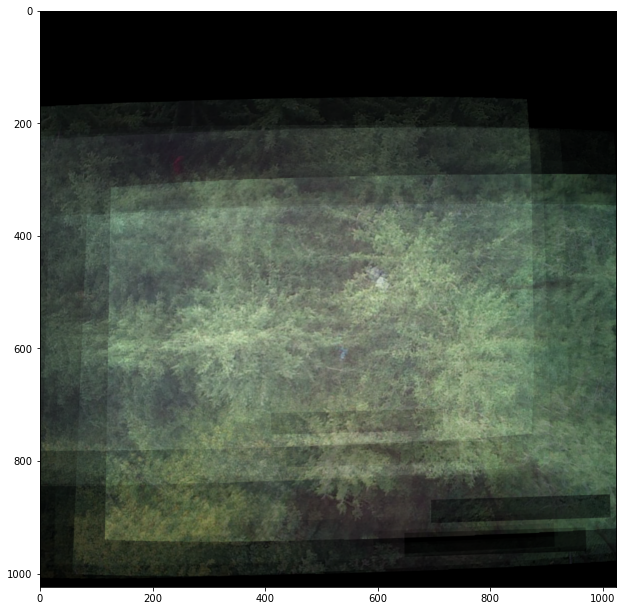

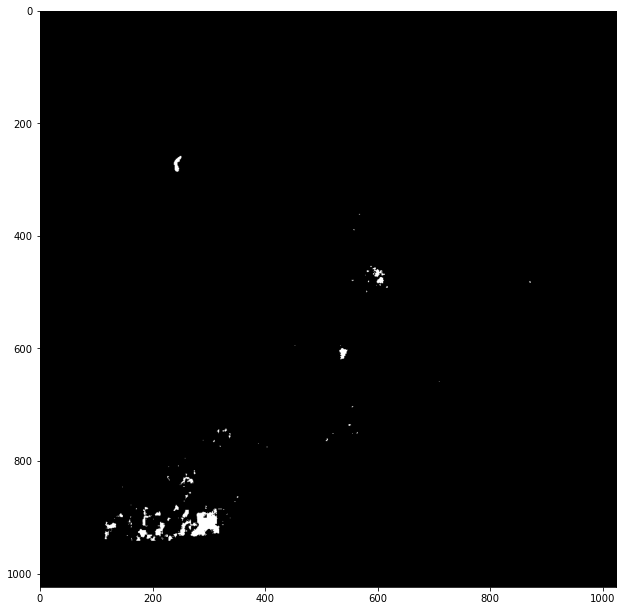

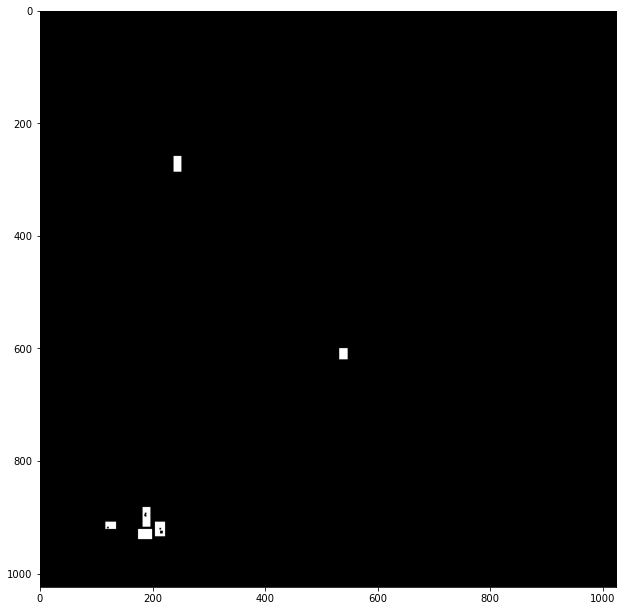

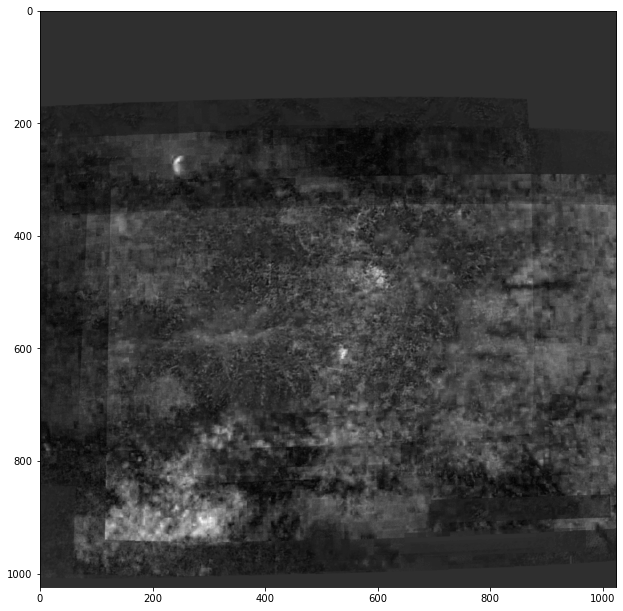

In [403]:
image = train_images['train-1-7-0']
distances, anomaly = mahalanobis(image, threshold=0.6)

anomaly_clean = cleanAnomaly(anomaly)
# 
plt.figure(figsize=(10.6, 10.6))
plt.imshow(image)
plt.figure(figsize=(10.6, 10.6))
plt.imshow(anomaly, cmap='gray')
plt.figure(figsize=(10.6, 10.6))
plt.imshow(anomaly_clean, cmap='gray')
plt.figure(figsize=(10.6, 10.6))
plt.imshow(distances, cmap='gray')
plt.show()

## Process all training images with modified RX detector

In [99]:
anomalies = []
keys = train_images.keys()

pbar = tqdm(keys)
for key in pbar:
    image = train_images[key]
    distances, anomaly = mahalanobis(image, threshold=0.6)
    anomaly_clean = cleanAnomaly(anomaly)
    anomalies.append(anomaly_clean)

  0%|          | 0/182 [00:00<?, ?it/s]

### Resize anomaly images for Autoencoder input

In [67]:
resized_anomalies = anomalies.copy()
for i, a in enumerate(anomalies):
    resized_anomalies[i] = torch.Tensor(cv2.resize(a, (512, 512), interpolation = cv2.INTER_AREA)).unsqueeze(0)

# Training

## Autoencoder Variants

In [233]:
class BinaryConvAutoEncoder(nn.Module):
    """ Convolutional auto-encoder. """
    
    def __init__(self, in_channels: int = 1, hid_channels: int = 64, code_channels: int = 256, 
                 kernel_size: int = 9, stride: int = 1, pooling: int = 2, 
                 activation: nn.Module = nn.ReLU()):
        """
        Parameters
        ----------
        in_channels : int
            Number of channels in the inputs.
        hid_channels : int
            Number of channels in the hidden layer(s).
        code_channels : int
            Number of channels in the code.
        kernel_size : int or tuple
            Window size for the convolutions
        stride : int or tuple, optional
            Window strides for the convolutions.
        pooling : int or tuple, optional
            Window size for the average pooling.
        activation : nn.Module, optional
            Activation function for the auto-encoder.
        """
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            activation,
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            activation
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, output_padding=0),
            activation,
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, output_padding=0),
            activation,
            nn.Conv2d(16, 1, kernel_size=4),
            nn.Tanh()
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

bcae = BinaryConvAutoEncoder()

In [327]:
class ConvAutoEncoder(nn.Module):
    """ Convolutional auto-encoder. """
    
    def __init__(self, in_channels: int = 1, hid_channels: int = 64, code_channels: int = 256, 
                 kernel_size: int = 9, stride: int = 1, pooling: int = 2, 
                 activation: nn.Module = nn.LeakyReLU()):
        """
        Parameters
        ----------
        in_channels : int
            Number of channels in the inputs.
        hid_channels : int
            Number of channels in the hidden layer(s).
        code_channels : int
            Number of channels in the code.
        kernel_size : int or tuple
            Window size for the convolutions
        stride : int or tuple, optional
            Window strides for the convolutions.
        pooling : int or tuple, optional
            Window size for the average pooling.
        activation : nn.Module, optional
            Activation function for the auto-encoder.
        """
        super().__init__()
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=9, stride=1),
            nn.BatchNorm2d(64),
            activation,
            nn.Conv2d(64, 128, kernel_size=5, stride=1),
            nn.BatchNorm2d(128),
            activation,
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            activation
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, output_padding=0),
            nn.BatchNorm2d(128),
            activation,
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, output_padding=0),
            nn.BatchNorm2d(64),
            activation,
            nn.ConvTranspose2d(64, 1, kernel_size=9, stride=1, output_padding=0),
            nn.BatchNorm2d(1),
            nn.Tanh()
        )
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=9, stride=1),
            nn.BatchNorm2d(16),
            activation,
            nn.Conv2d(16, 32, kernel_size=5, stride=1),
            nn.BatchNorm2d(32),
            activation,
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            activation
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, output_padding=0),
            nn.BatchNorm2d(32),
            activation,
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1, output_padding=0),
            nn.BatchNorm2d(16),
            activation,
            nn.ConvTranspose2d(16, 1, kernel_size=9, stride=1, output_padding=0),
            nn.BatchNorm2d(1),
            nn.Tanh()
        )        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

cae = ConvAutoEncoder()

In [328]:
from torchsummary import summary

summary(cae, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 504, 504]           1,312
       BatchNorm2d-2         [-1, 16, 504, 504]              32
         LeakyReLU-3         [-1, 16, 504, 504]               0
         LeakyReLU-4         [-1, 16, 504, 504]               0
            Conv2d-5         [-1, 32, 500, 500]          12,832
       BatchNorm2d-6         [-1, 32, 500, 500]              64
         LeakyReLU-7         [-1, 32, 500, 500]               0
         LeakyReLU-8         [-1, 32, 500, 500]               0
            Conv2d-9         [-1, 64, 498, 498]          18,496
      BatchNorm2d-10         [-1, 64, 498, 498]             128
        LeakyReLU-11         [-1, 64, 498, 498]               0
        LeakyReLU-12         [-1, 64, 498, 498]               0
  ConvTranspose2d-13         [-1, 32, 500, 500]          18,464
      BatchNorm2d-14         [-1, 32, 5

In [252]:
for i, a in enumerate(anomalies):
    resized_anomalies[i] = torch.Tensor(cv2.resize(a, (512, 512), interpolation = cv2.INTER_AREA)).unsqueeze(0)

In [329]:
workers = 2
batch_size = 8

if train:
    dataset = resized_anomalies
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)

    learning_rate = 1e-3
    criterion = nn.MSELoss()
    optimiser = torch.optim.Adam(cae.parameters(), lr=learning_rate, weight_decay=1e-5)
    num_epochs = 15
    for epoch in range(num_epochs):
        loss = 0
        for batch_features in dataloader:
            im = torch.squeeze(batch_features, dim=0)
            im = nn.functional.normalize(im)
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimiser.zero_grad()

            # compute reconstructions
            outputs = cae(im)
            # compute training reconstruction loss
            train_loss = criterion(outputs, im)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimiser.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss
        loss = loss / len(dataloader)

        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, num_epochs, loss))

epoch : 1/15, loss = 0.003064
epoch : 2/15, loss = 0.000842
epoch : 3/15, loss = 0.000580
epoch : 4/15, loss = 0.000416
epoch : 5/15, loss = 0.000303
epoch : 6/15, loss = 0.000312
epoch : 7/15, loss = 0.000235
epoch : 8/15, loss = 0.000208
epoch : 9/15, loss = 0.000132
epoch : 10/15, loss = 0.000116
epoch : 11/15, loss = 0.000113
epoch : 12/15, loss = 0.000085
epoch : 13/15, loss = 0.000082
epoch : 14/15, loss = 0.000059
epoch : 15/15, loss = 0.000059


In [330]:
if train:
    torch.save(cae, 'cae.pth')

In [254]:
if train:
    cae = torch.load('cae.pth', map_location='cpu')
    cae.eval();

## Process validation images (only the -3 = center camera) with modified RX detector to get 11 anomaly images

In [331]:
valid_anomalies = []
#keys = valid_images.keys()

valid_strings = {0: "valid-1-0", 1: "valid-1-1", 2: "valid-1-2", 3: "valid-1-3", 4: "valid-1-4", 5: "valid-1-5",
                 6: "valid-1-6", 7: "valid-2-0", 8: "valid-2-1", 9: "valid-2-2", 10: "valid-2-3"}

pbar = tqdm(range(len(valid_strings)))
for key in pbar:
    image = valid_images[valid_strings[key] + '-3']
    distances, anomaly = mahalanobis(image, threshold=0.6)
    anomaly_clean = cleanAnomaly(anomaly)
    valid_anomalies.append(anomaly_clean)

resized_valid_anomalies = valid_anomalies.copy()
for i, a in enumerate(valid_anomalies):
    resized_valid_anomalies[i] = torch.Tensor(cv2.resize(a, (1024, 1024), interpolation = cv2.INTER_AREA)).unsqueeze(0)    

  0%|          | 0/11 [00:00<?, ?it/s]

## Put validation anomaly images into trained Autoencoder

In [332]:
ae_output = []

pbar = tqdm(range(len(resized_valid_anomalies)))
for i in pbar:
    image = resized_valid_anomalies[i]
    image = image[np.newaxis]
    reconstructed = cae.forward(nn.functional.normalize(image))
    reconstructed = torch.squeeze(reconstructed.detach())
    ae_output.append(reconstructed)

  0%|          | 0/11 [00:00<?, ?it/s]

## Plot Autoencoder outputs

  0%|          | 0/11 [00:00<?, ?it/s]

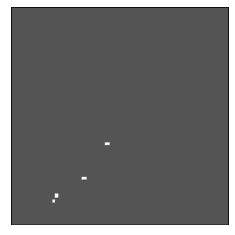

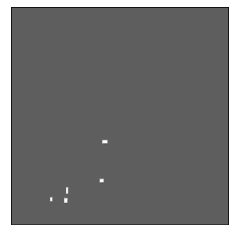

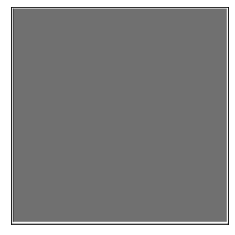

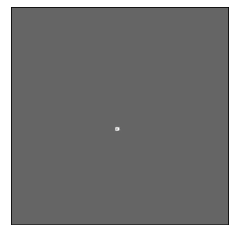

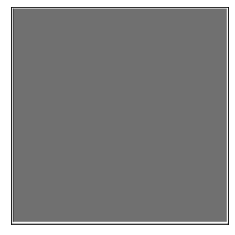

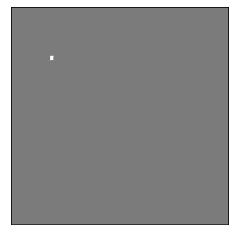

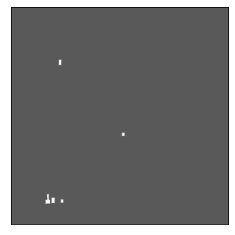

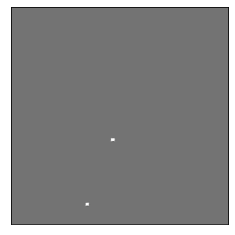

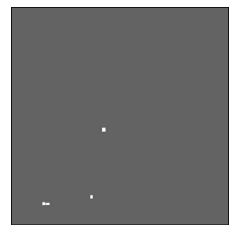

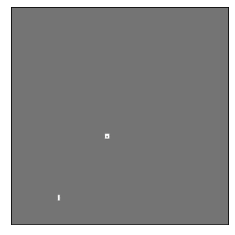

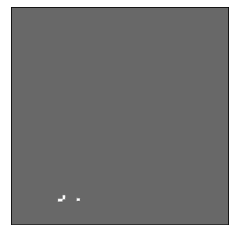

In [333]:
pbar = tqdm(range(len(resized_valid_anomalies)))

fig=plt.figure()
for i in pbar:
    fig.add_subplot(1,1,1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(ae_output[i], cmap='gray')
    plt.show()

## Get bounding box values and print to validation.json file

In [385]:
def getBoundingBoxValues(anomaly, area_max=500, area_min=200):
    anomaly = anomaly.cpu().detach().numpy()
    gray = anomaly.copy()

    # gray level needs to be ensured 'uint8'
    gray = gray.astype("uint8")

    blur = cv2.GaussianBlur(gray, (3,3), 0)

    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Filter using contour area and remove small noise
    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 5500:
            cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

    # Morph close and invert image
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4)) # change kernel size for bigger/smaller blurring
    close = 255 - cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Draw the bounding boxes on the filtered image
    gray_ = close.copy()


    # threshold
    thresh_ = cv2.threshold(gray_,128,255,cv2.THRESH_BINARY)[1]

    # get contours
    contours = cv2.findContours(thresh_, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    detected_boxes = []
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        detected_boxes.append([y,x,w,h])
        #cv2.rectangle(gray_, (x, y), (x+w, y+h), (0, 0, 255), 1)
        #cv2.rectangle(image_, (x, y), (x+w, y+h), (0, 0, 255), 1)
    #print('Box coordinates for detected objects (x,y,w,h):', detected_boxes)
    return detected_boxes

def getBoundingBoxValues_Simple(anomaly, area_max=400, area_min=100):
    anomaly = anomaly.cpu().detach().numpy()
    # Read image
    im = anomaly.copy().astype(np.uint8)

    # Detecting contours in image.
    contours,_ = cv2.findContours(im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bb_vals = []
    for contour in contours:
        cur_area = cv2.contourArea(contour)
        print(cur_area)
        if area_min < cur_area < area_max:
            x,y,w,h = cv2.boundingRect(contour)
            bb_vals.append([y, x, w, h])
            #bb_vals.append([x, y, w, h])

    return bb_vals

bb_pred_dict = dict()
pbar = tqdm(range(len(valid_strings)))
for j in pbar:
    bb_pred_dict[valid_strings[j]] = getBoundingBoxValues(ae_output[j])

result = str(bb_pred_dict)
result = result.replace("'", "\"")
print(result)
with open("validation.json","w") as file:
    file.write(result)

  0%|          | 0/11 [00:00<?, ?it/s]

{"valid-1-0": [[914, 199, 9, 9], [885, 208, 16, 16], [807, 336, 20, 9], [645, 449, 15, 9]], "valid-1-1": [[908, 253, 14, 17], [904, 187, 9, 12], [858, 261, 9, 22], [818, 421, 15, 10], [634, 433, 22, 12]], "valid-1-2": [], "valid-1-3": [[574, 502, 9, 11]], "valid-1-4": [], "valid-1-5": [[238, 186, 15, 17]], "valid-1-6": [[912, 167, 18, 15], [905, 193, 14, 21], [891, 172, 7, 12], [258, 227, 11, 18]], "valid-2-0": [[928, 353, 14, 11], [624, 474, 14, 12]], "valid-2-1": [[926, 151, 10, 10], [894, 375, 9, 10], [575, 430, 16, 17]], "valid-2-2": [[893, 222, 9, 20], [606, 455, 9, 15]], "valid-2-3": [[910, 224, 18, 9], [907, 313, 11, 10], [893, 245, 12, 16]]}


# Evaluation

In [388]:
import os
from typing import Dict, List

from utils import BoundingBox, compute_AP, read_bb

def evaluate(detections: Dict[str, List[BoundingBox]],
             targets: Dict[str, List[BoundingBox]]) -> float:
    return compute_AP(detections, targets)


# load the detections
detections = read_bb("validation.json")
# load the targets
targets = read_bb(os.path.join("data", "validation", "labels.json"))

ap = evaluate(detections, targets)
print(f"Average precision={ap:.5f} on validation set.")

Average precision=0.00267 on validation set.
